# X Sentiment Analysis
This notebook analyzes a dataset of tweets to classify their sentiment into three categories: **Positive**, **Negative**, or **Neutral**.

## 1. Importing Libraries & Loading Data

In [5]:
# Data handling
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier

# Gemini API
from google import genai
import os

## 2. Loading the Dataset
We load the Twitter Sentiment dataset and select only required columns.

In [7]:
df = pd.read_csv("Tweets.csv")  # Change path if needed

# Keep only relevant columns
df = df[['text', 'sentiment']]

# Remove missing values
df.dropna(inplace=True)

df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


## 3. Text Preprocessing and Cleaning
Text cleaning improves model performance by removing noise such as URLs, mentions, special characters, and converting text to lowercase.

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)    # remove mentions
    text = re.sub(r"#", "", text)       # remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special characters
    return text

df["clean_text"] = df["text"].apply(clean_text)

df.head()

,text,sentiment,clean_text
0,"I`d have responded, if I were going",neutral,id have responded if i were going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego
2,my boss is bullying me...,negative,my boss is bullying me
3,what interview! leave me alone,negative,what interview leave me alone
4,"Sons of ****, why couldn`t they put them on t...",negative,sons of why couldnt they put them on the rel...


##Exploratory Data Analysis (EDA)
### 4.1 Sentiment Distribution

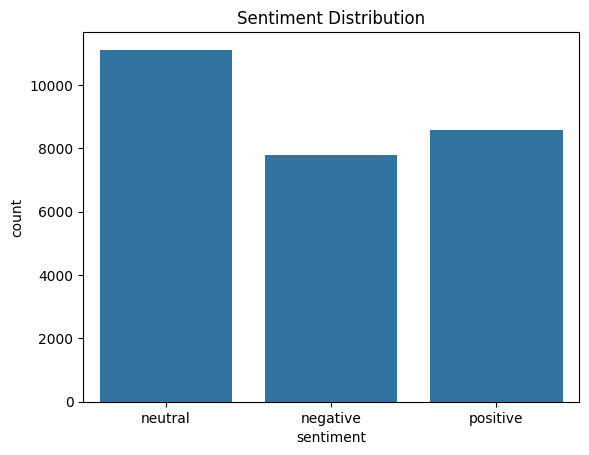

In [9]:
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Distribution")
plt.show()

### 4.2 Text Length Distribution

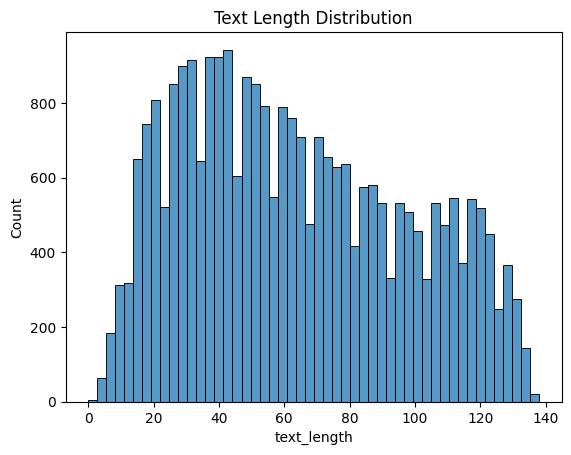

In [10]:
df["text_length"] = df["clean_text"].apply(len)

sns.histplot(df["text_length"], bins=50)
plt.title("Text Length Distribution")
plt.show()

## 5. Generating Embeddings using Gemini API
We use Gemini's embedding model to convert text into numerical vector representations

In [13]:
!pip install google-genai --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.63.0
    Uninstalling google-genai-1.63.0:
      Successfully uninstalled google-genai-1.63.0


In [14]:
from google import genai
import getpass

api_key = getpass.getpass("Enter your Gemini API key: ")
client = genai.Client(api_key=api_key)

Enter your Gemini API key: ··········


In [15]:
def get_embedding(text):
    response = client.models.embed_content(
        model="models/embedding-001",
        contents=text
    )
    return response.embeddings[0].values

### 6. Encoding Sentiment Labels

In [19]:
!pip install sentence-transformers

In [28]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")

df_sample = df.sample(3000, random_state=42)

X = model.encode(df_sample["clean_text"].tolist())

label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

y = df_sample["sentiment"].map(label_map)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## 7. Train-Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##8. Logistic Regression Model

In [23]:
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.645
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       173
           1       0.58      0.68      0.63       237
           2       0.71      0.68      0.70       190

    accuracy                           0.65       600
   macro avg       0.66      0.64      0.65       600
weighted avg       0.65      0.65      0.65       600



## 9. XGBoost Model (Advanced Classifier)

In [24]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [12:22:56] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.625


##10. Confusion Matrix (Best Model)

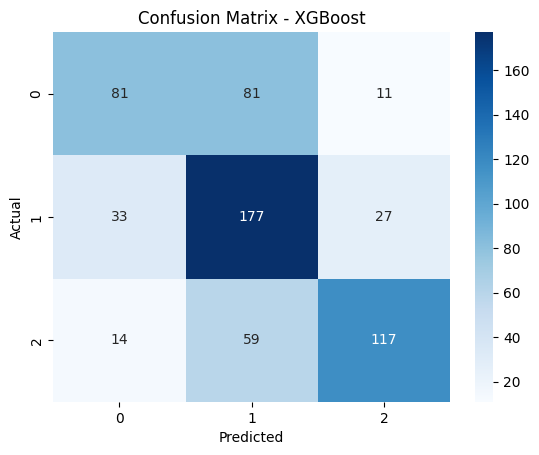

In [25]:
cm = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##11. Cosine Similarity Analysis

In [26]:
similarity_matrix = cosine_similarity(X_test)

print("Cosine Similarity Matrix Shape:", similarity_matrix.shape)

Cosine Similarity Matrix Shape: (600, 600)


##12. Custom Tweet Predictions

In [29]:
custom_tweets = [
    "The update ruined everything, nothing works properly anymore.",
    "Customer support responded quickly and solved my issue.",
    "It's okay, not great but not terrible either.",
    "I regret buying this product, total waste of money.",
    "Surprisingly impressed with the performance so far."
]

# Generate embeddings using the same trained embedding model
custom_embeddings = model.encode(custom_tweets)

# Predict sentiment using trained XGBoost model
predictions = xgb_model.predict(custom_embeddings)

# Convert numeric predictions back to readable labels
reverse_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

print("----- Custom Tweet Predictions -----\n")

for tweet, pred in zip(custom_tweets, predictions):
    print("Tweet:", tweet)
    print("Predicted Sentiment:", reverse_map[pred])
    print()

----- Custom Tweet Predictions -----

Tweet: The update ruined everything, nothing works properly anymore.
Predicted Sentiment: Negative

Tweet: Customer support responded quickly and solved my issue.
Predicted Sentiment: Negative

Tweet: It's okay, not great but not terrible either.
Predicted Sentiment: Neutral

Tweet: I regret buying this product, total waste of money.
Predicted Sentiment: Negative

Tweet: Surprisingly impressed with the performance so far.
Predicted Sentiment: Positive

